# Unfair Regression

Generate a regression dataset with sensitive groups and visualize group-level fairness metrics.


## Overview

This notebook covers:
- Dataset generation with group-level unfairness
- Quick data inspection and group summaries
- Model training and regression fairness metrics
- Comparison across fairness types

Key functions:
- `make_unfair_regression`
- `train_and_evaluate_model_with_regressor`
- `visualize_regression_metrics`


In [82]:
# Required Imports

import sys
import os

sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
from IPython.display import display

from unfair_data_generator.unfair_regression import make_unfair_regression
from unfair_data_generator.util.model_trainer import train_and_evaluate_model_with_regressor
from unfair_data_generator.util.visualizer import visualize_regression_metrics

## 1. Parameters

Key inputs: `n_samples`, `n_features`, `n_informative`, `fairness_type`, `base_function`, `n_sensitive_groups`.


In [83]:
# Dataset configuration

n_samples = 3000
n_features = 10
n_informative = 3
random_state = 42

# Options: "Equal MSE", "Group bias", "Heteroscedastic noise"
fairness_type = "Group bias"
# Options: "linear", "logistic", "sigmoid", "exponential"
base_function = "linear"
n_sensitive_groups = 3

fairness_types = ["Equal MSE", "Group bias", "Heteroscedastic noise"]

## 2. Generate dataset


In [84]:
X, y, Z = make_unfair_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    fairness_type=fairness_type,
    base_function=base_function,
    n_sensitive_groups=n_sensitive_groups,
    random_state=random_state
)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("Z:", Z.shape)


Shapes:
X: (3000, 10)
y: (3000,)
Z: (3000,)


## Generated data

- `X` comes from the shared feature generation pipeline.
- `Z` contains sensitive group labels (weather group names are used in reports).
- `y` is a continuous target built from a base signal plus group-specific bias and noise.


## 3. Inspect data


In [85]:
df = pd.DataFrame(X, columns=[f"x{i}" for i in range(X.shape[1])])
df["y"] = y
df["Z"] = Z

df.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y,Z
0,-0.400390,0.494180,1.079003,-1.147419,-0.207941,0.168723,0.230181,0.079074,0.344609,2.191770,1.198980,2
1,-1.403076,0.991553,0.167939,-1.209642,-0.453236,0.155579,-1.070754,0.966093,0.560281,-1.986291,-0.769320,1
2,0.276010,-1.195390,0.548051,0.182518,-0.056975,-0.082143,1.814649,0.100804,1.654668,0.220323,2.238876,1
3,0.963410,1.659650,2.090183,-1.554685,0.314902,-0.733462,-0.889963,-0.276132,-1.088628,0.121034,0.670160,1
4,-3.330314,-2.189120,-1.078350,-0.219469,-1.348945,2.191638,-1.181567,0.220129,-1.740701,-0.399071,0.546654,0


## 4. Group target summary


In [86]:
df.groupby("Z")["y"].describe()


,count,mean,std,min,25%,50%,75%,max
Z,,,,,,,,
0,1000.0,1.845636,2.290411,-3.320604,-0.067047,1.724118,3.757647,7.403475
1,1000.0,1.431432,1.635233,-3.385646,0.256915,1.409954,2.586931,6.459867
2,1000.0,1.585315,1.450752,-2.242077,0.580908,1.559404,2.566236,6.256665


## 5. Train and evaluate

Metrics: RMSE, MAE, mean residual, R2.


In [87]:
metrics = train_and_evaluate_model_with_regressor(X, y, Z)


## 6. Metric comparison table

RMSE emphasizes large errors, MAE is average error magnitude, mean residual shows systematic over/underestimation.


In [88]:
metrics_df = pd.DataFrame.from_dict(metrics, orient="index")
metrics_df = metrics_df[["RMSE", "MAE", "Mean residual", "R2", "Samples"]]
metrics_df


,RMSE,MAE,Mean residual,R2,Samples
Sunny,0.459178,0.365335,0.196517,0.959149,287
Cloudy,0.351815,0.281052,0.120465,0.951220,314
Rainy,0.394790,0.305993,-0.274607,0.928702,299


## 7. Compare fairness types

Generate datasets for each fairness type and compare group-level metrics.


In [89]:
comparison_results = {}
comparison_tables = {}

for ft in fairness_types:
    X_ft, y_ft, Z_ft = make_unfair_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        fairness_type=ft,
        base_function=base_function,
        n_sensitive_groups=n_sensitive_groups,
        random_state=random_state
    )
    metrics_ft = train_and_evaluate_model_with_regressor(X_ft, y_ft, Z_ft)
    comparison_results[ft] = metrics_ft
    comparison_tables[ft] = pd.DataFrame.from_dict(metrics_ft, orient="index")

for ft, table in comparison_tables.items():
    print(ft)
    display(table[["RMSE", "MAE", "Mean residual", "R2", "Samples"]])


Equal MSE


,RMSE,MAE,Mean residual,R2,Samples
Sunny,0.309187,0.224386,-0.016027,0.981478,287
Cloudy,0.210025,0.159470,0.002226,0.982616,314
Rainy,0.202577,0.147457,0.021243,0.981227,299


Group bias


,RMSE,MAE,Mean residual,R2,Samples
Sunny,0.459178,0.365335,0.196517,0.959149,287
Cloudy,0.351815,0.281052,0.120465,0.951220,314
Rainy,0.394790,0.305993,-0.274607,0.928702,299


Heteroscedastic noise


,RMSE,MAE,Mean residual,R2,Samples
Sunny,0.312744,0.228274,-0.021455,0.981050,287
Cloudy,0.280677,0.220508,0.013363,0.969400,314
Rainy,0.360336,0.283942,0.041821,0.943958,299


## 9. Visual comparison


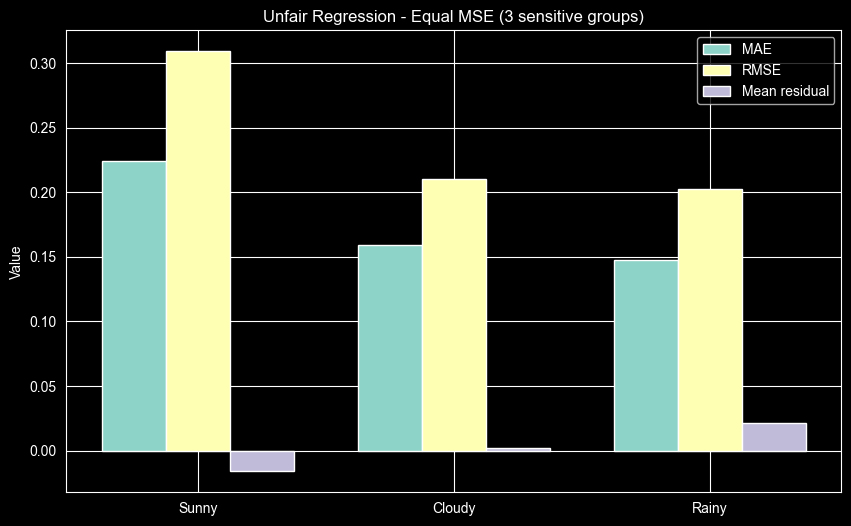

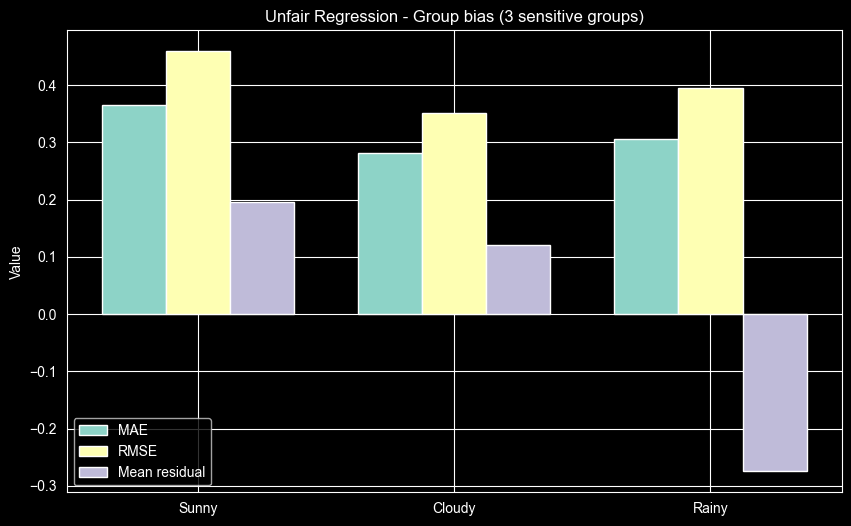

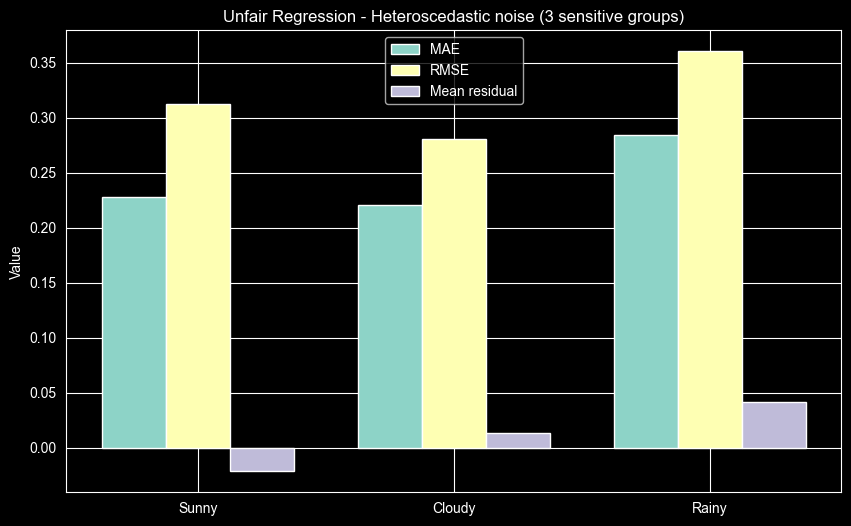

In [90]:
for ft, metrics_ft in comparison_results.items():
    title = f"Unfair Regression - {ft} ({n_sensitive_groups} sensitive groups)"
    visualize_regression_metrics(metrics_ft, title)
